<a href="https://colab.research.google.com/github/SDS-AAU/DSBA-2022/blob/master/static/notebooks/M2_assignment_example1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1

Data augmentation: Use NLP techniques to create categories for the different positions (these are only free-text at the moment) and create a consistent industry column. Impute (predict) the education requirements for all jobs. You can use different strategies to create larger labels for the freetext, including (but not limitd to):

* Hand labeling of several jobs, and use these to predict for the remaining labels.
* Do a topic modeling on the job description, and label them with the topic most associated.
* Do something else… (eg. cluster job descriptions by TFIDF-weighted DTM…)

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import spacy 
nlp = spacy.load('en_core_web_sm') 

from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.cluster import KMeans
from collections import Counter

import matplotlib.pyplot as plt

#### 1.1. Loading and cleaning the data

In [ ]:
import itertools
import numpy as np 
import pandas as pd
import tqdm
!pip install preprocessor
import preprocessor as prepro
import spacy #spacy for quick language prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import itertools
import random
import networkx as nx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for preprocessor: filename=preprocessor-1.1.3-py3-none-any.whl size=4477 sha256=13ef8528329c92486ab1f9eeb7b3ab5fb36dd2d361b69ddfeba15394ab6ea5dd
  Stored in directory: /root/.cache/pip/wheels/0e/b7/36/aa37256db62b4bfd35a6f1b5536e9ba843f257b79dcbf3d5f1
Successfully built preprocessor


In [ ]:
!wget https://github.com/aaubs/ds-master/raw/main/data/Job_search.zip

--2022-11-11 14:59:24--  https://github.com/aaubs/ds-master/raw/main/data/Job_search.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aaubs/ds-master/main/data/Job_search.zip [following]
--2022-11-11 14:59:24--  https://raw.githubusercontent.com/aaubs/ds-master/main/data/Job_search.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6862703 (6.5M) [application/zip]
Saving to: ‘Job_search.zip’

Job_search.zip      100%[===================>]   6.54M  --.-KB/s    in 0.1s    

2022-11-11 14:59:25 (46.2 MB/s) - ‘Job_search.zip’ saved [6862703/6862703]



In [ ]:
!unzip Job_search.zip

Archive:  Job_search.zip
   creating: Job_search/
  inflating: __MACOSX/._Job_search   
  inflating: Job_search/user_work_interest.csv  
  inflating: __MACOSX/Job_search/._user_work_interest.csv  
  inflating: Job_search/.DS_Store    
  inflating: __MACOSX/Job_search/._.DS_Store  
  inflating: Job_search/user_job_views.csv  
  inflating: __MACOSX/Job_search/._user_job_views.csv  
  inflating: Job_search/user_past_experience.csv  
  inflating: __MACOSX/Job_search/._user_past_experience.csv  
  inflating: Job_search/jobs.csv     
  inflating: __MACOSX/Job_search/._jobs.csv  


In [ ]:
data = pd.read_csv('Job_search/jobs.csv')

In [ ]:
def text_prepro(texts):

  texts_clean = texts.str.lower() #lowering all words in the rows

  #getting rid of the - in full/part time 
  texts_clean = texts_clean.str.replace('part-time', 'part time') 
  texts_clean = texts_clean.str.replace('full-time', 'full time')
  texts_clean = texts_clean.str.replace('part - time', 'part time')
  texts_clean = texts_clean.str.replace('full - time', 'full time')

  texts_clean = texts_clean.str.replace('time', '') #gettind rid of the word 'time' ('full' and 'part' will be removed later as 
                                                      #they're not nouns)

  texts_clean = texts_clean.str.split('@').str[0] #getting rid of the text after the '@' (usually the company's name)
 
  clean_container = []

  for text in nlp.pipe(texts_clean):

    txt = [token.text for token in text 
      if token.is_alpha #getting rid of numbers
      and token.pos_ in ['NOUN'] #taking only nouns
      and not token.is_stop #getting rid of stop words
      and not token.is_punct] #getting rid of puntuation signs
      
      
    clean_container.append(" ".join(txt))
  
  return clean_container

In [ ]:
data['Title_clean'] = text_prepro(data['Title'])

In [ ]:
(data['Title_clean'] == "").value_counts() #with this preprocessing we're sacrifying 352 out of 12370 jobs 

False    12018
True       352
Name: Title_clean, dtype: int64

In [ ]:
#getting rid of empty rows
data['Title_clean'].replace('', np.nan, inplace=True)
data.dropna(subset=['Title_clean'], inplace=True)

In [ ]:
data_df = pd.DataFrame({'text':data['Title_clean']})

In [ ]:
data_df

,text
0,cashiers valets
1,fragrance cashier garden city ny field
2,showroom sales cashier
3,event specialist
4,bonefish kitchen staff
...,...
12365,server
12366,server
12367,server
12368,server


#### 1.2. Clustering

##### 1.2.1. TfidVectorizer

In [ ]:
corpus = data_df['text'].values

In [ ]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)

In [ ]:
vector = vectorizer.fit_transform(corpus)

##### 1.2.2. Finding out the k for KMeans

In [ ]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(vector)
    Sum_of_squared_distances.append(km.inertia_)

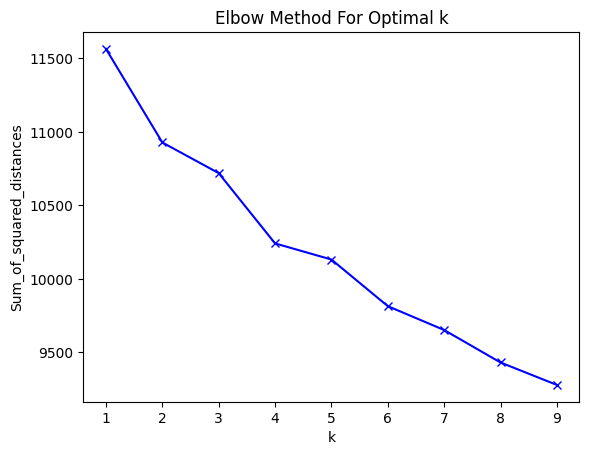

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.savefig('kmeans2.png') #idk why it doesn't show the plot with plt.show - I'm here saving the image to then show it in markdown

In [ ]:
true_k = 6

##### 1.2.3. KMeans

In [ ]:
clusterer = KMeans(n_clusters=true_k)

In [ ]:
clusterer.fit(vector)

KMeans(n_clusters=6)

In [ ]:
data_df['cluster'] = clusterer.labels_

In [ ]:
data_df

,text,cluster
0,cashiers valets,4
1,fragrance cashier garden city ny field,4
2,showroom sales cashier,2
3,event specialist,4
4,bonefish kitchen staff,4
...,...,...
12365,server,4
12366,server,4
12367,server,4
12368,server,4


#### 1.3. Displaying the most frequent words for each cluster

In [ ]:
arrayOfWordInCluster = []
for line in data_df.loc[data_df['cluster']==0]['text']:
    for word in line.split():
        arrayOfWordInCluster.append(word)

counts = Counter(arrayOfWordInCluster)
print(counts.most_common(10))

[('driver', 283), ('delivery', 229), ('job', 105), ('drivers', 87), ('team', 85), ('bikers', 84), ('inventory', 28), ('associate', 28), ('bus', 15), ('school', 14)]


In [ ]:
arrayOfWordInCluster = []
for line in data_df.loc[data_df['cluster']==1]['text']:
    for word in line.split():
        arrayOfWordInCluster.append(word)

counts = Counter(arrayOfWordInCluster)
print(counts.most_common(10))

[('assistant', 982), ('manager', 130), ('office', 61), ('resources', 24), ('hr', 13), ('support', 12), ('care', 11), ('teacher', 11), ('project', 11), ('nursing', 9)]


In [ ]:
arrayOfWordInCluster = []
for line in data_df.loc[data_df['cluster']==2]['text']:
    for word in line.split():
        arrayOfWordInCluster.append(word)

counts = Counter(arrayOfWordInCluster)
print(counts.most_common(10))

[('sales', 1309), ('associate', 234), ('toys', 203), ('team', 203), ('member', 203), ('consultant', 188), ('representative', 102), ('babies', 99), ('center', 51), ('event', 49)]


In [ ]:
arrayOfWordInCluster = []
for line in data_df.loc[data_df['cluster']==3]['text']:
    for word in line.split():
        arrayOfWordInCluster.append(word)

counts = Counter(arrayOfWordInCluster)
print(counts.most_common(10))

[('receptionist', 370), ('officer', 75), ('security', 60), ('desk', 20), ('assistant', 9), ('concierge', 5), ('healthcare', 4), ('cape', 3), ('office', 3), ('secretary', 3)]


In [ ]:
arrayOfWordInCluster = []
for line in data_df.loc[data_df['cluster']==4]['text']:
    for word in line.split():
        arrayOfWordInCluster.append(word)

counts = Counter(arrayOfWordInCluster)
print(counts.most_common(10))

[('clerk', 504), ('security', 418), ('entry', 360), ('specialist', 327), ('officer', 317), ('cashier', 310), ('associate', 290), ('stock', 286), ('assistant', 283), ('toys', 256)]


In [ ]:
arrayOfWordInCluster = []
for line in data_df.loc[data_df['cluster']==5]['text']:
    for word in line.split():
        arrayOfWordInCluster.append(word)

from collections import Counter
counts = Counter(arrayOfWordInCluster)
print(counts.most_common(10))

[('service', 858), ('customer', 839), ('representative', 375), ('sales', 187), ('associate', 134), ('entry', 93), ('level', 90), ('event', 84), ('store', 83), ('home', 77)]


# Exercise 2

Use a 2-mode network approach based on the “traffic-data” to create job recommendation. Example:
* create a network user_id - job_id
* project to user_id
* recommend to user_i what user_y also looked at if they are close to each other e.g. 1 jump away (and job is in the same city, state, fits user_i past experience, fits user_j interests…)

#### 2.1. Creating the network

In [ ]:
df2 = data[['Applicant.ID', 'Job.ID']]

In [ ]:
df2

,Applicant.ID,Job.ID
0,10000,73666
1,10000,96655
2,10001,84141
3,10002,77989
4,10002,69568
...,...,...
12365,9997,166
12366,9997,531
12367,9997,33
12368,9997,517


In [ ]:
# creating a link between people that has applied to the same job
network = pd.merge(df2, df2, on=df2['Job.ID'])

In [ ]:
network = network[['Applicant.ID_x', 'Job.ID_x', 'Applicant.ID_y']]

In [ ]:
network = network[network['Applicant.ID_x'] != network['Applicant.ID_y']] #deleting connection between one and itself

In [ ]:
# here, we can see people that has applied for the same job with the Job.ID as edge
network

,Applicant.ID_x,Job.ID_x,Applicant.ID_y
1,10000,73666,11268
2,10000,73666,11478
3,11268,73666,10000
5,11268,73666,11478
6,11478,73666,10000
...,...,...,...
72200,9995,196,9997
72201,9997,196,9954
72202,9997,196,9995
72262,9995,531,9997


In [ ]:
G = nx.from_pandas_edgelist(network, source = 'Applicant.ID_x', target = 'Applicant.ID_y')

#### 2.2. Creating the dictionary with the node's attributes 

For the attributes, we will work with the city and the states of the applicant jobs applications. The recommendation system will recommend a person jobs that are in the same city as well as jobs that are in the same states

In [ ]:
city_df= data[['Applicant.ID', 'City', 'State.Code']]

In [ ]:
city_df

,Applicant.ID,City,State.Code
0,10000,Newark,NJ
1,10000,Garden City,NY
2,10001,Bellingham,WA
3,10002,Simpsonville,SC
4,10002,Greenville,SC
...,...,...,...
12365,9997,San Francisco,CA
12366,9997,San Francisco,CA
12367,9997,Oakland,CA
12368,9997,San Francisco,CA


In [ ]:
# grouping by applicant ids
df2 = city_df.groupby('Applicant.ID', as_index=False).agg(
    City = pd.NamedAgg(column='City', aggfunc=list),
    State = pd.NamedAgg(column='State.Code', aggfunc=list)
)

In [ ]:
df2

,Applicant.ID,City,State
0,42,"[San Francisco, San Francisco, San Francisco, ...","[CA, CA, CA, CA]"
1,96,"[San Francisco, San Francisco, Burlingame]","[CA, CA, CA]"
2,153,"[Citrus Heights, Citrus Heights, Citrus Height...","[CA, CA, CA, CA, CA, CA, CA, CA, CA, CA, CA, C..."
3,601,"[Bay Area, San Francisco, Dededo, Palo Alto, P...","[CA, CA, nan, CA, CA, CA, NY, NY, NY, NY, CA, ..."
4,1877,[Sunnyvale],[CA]
...,...,...,...
3384,14546,"[los angeles, los angeles, los angeles]","[CA, CA, CA]"
3385,14547,"[New York, New York]","[NY, NY]"
3386,14549,[New York],[NY]
3387,14552,[New York],[NY]


In [ ]:
#removing duplicate values in cities and in states
for i in range(len(df2)):
    df2.City[i] = list(dict.fromkeys(df2.City[i]))
    df2.State[i] = list(dict.fromkeys(df2.State[i]))

/var/folders/qh/sb22brg10nz7b84l6bfjcvq00000gn/T/ipykernel_10632/501912744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.City[i] = list(dict.fromkeys(df2.City[i]))
/var/folders/qh/sb22brg10nz7b84l6bfjcvq00000gn/T/ipykernel_10632/501912744.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.State[i] = list(dict.fromkeys(df2.State[i]))


In [ ]:
df2

,Applicant.ID,City,State
0,42,[San Francisco],[CA]
1,96,"[San Francisco, Burlingame]",[CA]
2,153,"[Citrus Heights, Roseville, San Jose, Fremont,...",[CA]
3,601,"[Bay Area, San Francisco, Dededo, Palo Alto, N...","[CA, nan, NY, CT, FL]"
4,1877,[Sunnyvale],[CA]
...,...,...,...
3384,14546,[los angeles],[CA]
3385,14547,[New York],[NY]
3386,14549,[New York],[NY]
3387,14552,[New York],[NY]


In [ ]:
node_attr = df2.set_index('Applicant.ID').T.to_dict()

In [ ]:
nx.set_node_attributes(G, node_attr)

#### 2.3. Creating recommendation functions

In [ ]:
def getRecForApplID(applicantId):

    applicantNeighbors = list(G.neighbors(applicantId)) #looking for node's neighbors

    res =  data[data['Applicant.ID'].isin(applicantNeighbors)]

    res = res.drop_duplicates(subset=['Job.ID']) #removing duplicated recommended jobs (same jobs being recommended by different neighbors)

    return res

In [ ]:
def getRecForApplIDWithCity(applicantId):

    applicantNeighbors = list(G.neighbors(applicantId)) #looking for node's neighbors
    applicantCities = G.nodes()[applicantId]['City'] #looking for node's cities

    res =  data[data['Applicant.ID'].isin(applicantNeighbors) 
        & (data['City'].isin(applicantCities))]

    res = res.drop_duplicates(subset=['Job.ID']) #removing duplicated recommended jobs (same jobs being recommended by different neighbors)

    return res


In [ ]:
def getRecForApplIDWithStates(applicantId):

    applicantNeighbors = list(G.neighbors(applicantId))
    applicantStates = G.nodes()[applicantId]['State'] #looking for node's states

    res =  data[data['Applicant.ID'].isin(applicantNeighbors) 
        & data['State.Code'].isin(applicantStates)]

    res = res.drop_duplicates(subset=['Job.ID'])

    return res

#### 2.4. Recommendation examples

##### 2.4.1. Recommendations for applicant 10000

Applicant 10000 information:

In [ ]:
applicantNeighbors = list(G.neighbors(10000)) 
applicantCities = G.nodes()[10000]['City']
applicantStates = G.nodes()[10000]['State']

print('Applicant id 10000 neigbors are: ')
print(', '.join(map(str, applicantNeighbors)))
print('Applicant 10000 has applied for jobs in the following cities: ')
print(', '.join(map(str, applicantCities)))
print('and in the following states: ')
print(', '.join(map(str, applicantStates)))

Applicant id 10000 neigbors are: 
11268, 11478, 9489, 9807
Applicant 10000 has applied for jobs in the following cities: 
Newark, Garden City
and in the following states: 
NJ, NY


Recommendations for user 10000:

In [ ]:
getRecForApplID(10000)

,Applicant.ID,Job.ID,Title,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At,Title_clean
2413,11268,73666,Cashiers & Valets Needed! @ WallyPark,WallyPark,Newark,New Jersey,NJ,NaN,2015-01-03 18:36:14 UTC,2015-01-03 18:36:36 UTC,21.0,2015-01-03 18:36:14 UTC,2015-01-03 18:36:14 UTC,cashiers valets
2414,11268,157861,"Retail Positions Available: Produce, Deli, Bak...",NaN,Bronx,New York,NY,NaN,2015-01-03 18:36:42 UTC,2015-01-03 18:37:10 UTC,27.0,2015-01-03 18:36:42 UTC,2015-01-03 18:36:42 UTC,positions deli bakery cashiers
2415,11268,99081,Toys R Us Seasonal Off Hours Stock Crew @ Toys...,"Toys ""R"" Us, Inc",Brooklyn,New York,NY,NaN,2015-01-03 18:37:35 UTC,2015-01-03 18:37:43 UTC,8.0,2015-01-03 18:37:35 UTC,2015-01-03 18:37:35 UTC,toys hours stock crew
2949,11478,91953,Package Handler - Part-Time @ UPS,UPS,Newark,New Jersey,NJ,NaN,2015-01-05 23:45:04 UTC,2015-01-05 23:55:33 UTC,628.0,2015-01-05 23:45:04 UTC,2015-01-05 23:45:04 UTC,handler
11501,9489,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City,New York,NY,NaN,2014-12-05 18:56:42 UTC,NaN,NaN,2014-12-05 18:56:42 UTC,2014-12-05 18:56:42 UTC,fragrance cashier garden city ny field
12055,9807,61392,Visitor Experience Assistant (Part-time) @ Jsp...,"Jspace, LLC",New York,New York,NY,NaN,2014-12-10 01:51:44 UTC,2014-12-10 01:51:52 UTC,7.0,2014-12-10 01:51:44 UTC,2014-12-10 01:51:44 UTC,visitor experience assistant
12056,9807,80229,"Restaurat - Line Cook / Prep Cook, Dish Prep /...",Olive Garden,Manhattan,New York,NY,NaN,2014-12-10 01:52:14 UTC,2014-12-10 01:52:31 UTC,17.0,2014-12-10 01:52:14 UTC,2014-12-10 01:52:14 UTC,line cook prep production dishwasher


Recommendations for user 10000 at the same cities as the ones he has applied for jobs in:

In [ ]:
getRecForApplIDWithCity(10000)

,Applicant.ID,Job.ID,Title,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At,Title_clean
2413,11268,73666,Cashiers & Valets Needed! @ WallyPark,WallyPark,Newark,New Jersey,NJ,NaN,2015-01-03 18:36:14 UTC,2015-01-03 18:36:36 UTC,21.0,2015-01-03 18:36:14 UTC,2015-01-03 18:36:14 UTC,cashiers valets
2949,11478,91953,Package Handler - Part-Time @ UPS,UPS,Newark,New Jersey,NJ,NaN,2015-01-05 23:45:04 UTC,2015-01-05 23:55:33 UTC,628.0,2015-01-05 23:45:04 UTC,2015-01-05 23:45:04 UTC,handler
11501,9489,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City,New York,NY,NaN,2014-12-05 18:56:42 UTC,NaN,NaN,2014-12-05 18:56:42 UTC,2014-12-05 18:56:42 UTC,fragrance cashier garden city ny field


Recommendations for user 10000 at the same states as the ones he has applied for jobs in:

In [ ]:
getRecForApplIDWithStates(10000)

,Applicant.ID,Job.ID,Title,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At,Title_clean
2413,11268,73666,Cashiers & Valets Needed! @ WallyPark,WallyPark,Newark,New Jersey,NJ,NaN,2015-01-03 18:36:14 UTC,2015-01-03 18:36:36 UTC,21.0,2015-01-03 18:36:14 UTC,2015-01-03 18:36:14 UTC,cashiers valets
2414,11268,157861,"Retail Positions Available: Produce, Deli, Bak...",NaN,Bronx,New York,NY,NaN,2015-01-03 18:36:42 UTC,2015-01-03 18:37:10 UTC,27.0,2015-01-03 18:36:42 UTC,2015-01-03 18:36:42 UTC,positions deli bakery cashiers
2415,11268,99081,Toys R Us Seasonal Off Hours Stock Crew @ Toys...,"Toys ""R"" Us, Inc",Brooklyn,New York,NY,NaN,2015-01-03 18:37:35 UTC,2015-01-03 18:37:43 UTC,8.0,2015-01-03 18:37:35 UTC,2015-01-03 18:37:35 UTC,toys hours stock crew
2949,11478,91953,Package Handler - Part-Time @ UPS,UPS,Newark,New Jersey,NJ,NaN,2015-01-05 23:45:04 UTC,2015-01-05 23:55:33 UTC,628.0,2015-01-05 23:45:04 UTC,2015-01-05 23:45:04 UTC,handler
11501,9489,96655,Macy's Seasonal Retail Fragrance Cashier - Ga...,Macy's,Garden City,New York,NY,NaN,2014-12-05 18:56:42 UTC,NaN,NaN,2014-12-05 18:56:42 UTC,2014-12-05 18:56:42 UTC,fragrance cashier garden city ny field
12055,9807,61392,Visitor Experience Assistant (Part-time) @ Jsp...,"Jspace, LLC",New York,New York,NY,NaN,2014-12-10 01:51:44 UTC,2014-12-10 01:51:52 UTC,7.0,2014-12-10 01:51:44 UTC,2014-12-10 01:51:44 UTC,visitor experience assistant
12056,9807,80229,"Restaurat - Line Cook / Prep Cook, Dish Prep /...",Olive Garden,Manhattan,New York,NY,NaN,2014-12-10 01:52:14 UTC,2014-12-10 01:52:31 UTC,17.0,2014-12-10 01:52:14 UTC,2014-12-10 01:52:14 UTC,line cook prep production dishwasher


We can see how neighbour 9807 is not shown in the city function, whereas we can see that is present in the states one. This is because applicant 9807 has applied for jobs in the same states as applicant 10000 but hasn't applied for jobs in the same city, and that why jobs applicant 9807 have applied to, aren't shown in the city job recommendations

##### 2.4.2. Recommendations for applicant 11268

Applicant 11268 information:

In [ ]:
applicantNeighbors = list(G.neighbors(12615)) 
applicantCities = G.nodes()[12615]['City']
applicantStates = G.nodes()[12615]['State']

print('Applicant id 11268 neigbors are: ')
print(', '.join(map(str, applicantNeighbors)))
print('Applicant id 11268 has applied for jobs in the following cities: ')
print(', '.join(map(str, applicantCities)))
print('and in the following states: ')
print(', '.join(map(str, applicantStates)))

Applicant id 11268 neigbors are: 
10516, 10540, 11268, 12298, 12764, 13488, 13498
Applicant id 11268 has applied for jobs in the following cities: 
Brooklyn
and in the following states: 
NY


Recommendations for user 10000:

In [ ]:
getRecForApplID(12615)

,Applicant.ID,Job.ID,Title,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At,Title_clean
970,10516,99081,Toys R Us Seasonal Off Hours Stock Crew @ Toys...,"Toys ""R"" Us, Inc",Brooklyn,New York,NY,NaN,2014-12-21 20:17:09 UTC,2014-12-21 20:17:29 UTC,20.0,2014-12-21 20:17:09 UTC,2014-12-21 20:17:09 UTC,toys hours stock crew
972,10516,79736,Retail Sales Associate / Photographer (Seasona...,J. C. Penney Portrait Studios,Brooklyn,New York,NY,NaN,2014-12-21 20:20:37 UTC,2014-12-21 20:20:46 UTC,8.0,2014-12-21 20:20:37 UTC,2014-12-21 20:20:37 UTC,sales associate photographer
974,10516,84168,Track Equipment Maintainer @ MTA New York City...,MTA New York City Transit,Brooklyn,New York,NY,NaN,2014-12-21 20:16:12 UTC,2014-12-21 20:16:47 UTC,34.0,2014-12-21 20:16:12 UTC,2014-12-21 20:16:12 UTC,track equipment maintainer
976,10516,150667,Housekeeper @ New York Sports Clubs,New York Sports Clubs,Hawthorne,New York,NY,NaN,2014-12-21 20:23:39 UTC,2014-12-21 20:24:30 UTC,51.0,2014-12-21 20:23:39 UTC,2014-12-21 20:23:39 UTC,housekeeper
2413,11268,73666,Cashiers & Valets Needed! @ WallyPark,WallyPark,Newark,New Jersey,NJ,NaN,2015-01-03 18:36:14 UTC,2015-01-03 18:36:36 UTC,21.0,2015-01-03 18:36:14 UTC,2015-01-03 18:36:14 UTC,cashiers valets
2414,11268,157861,"Retail Positions Available: Produce, Deli, Bak...",NaN,Bronx,New York,NY,NaN,2015-01-03 18:36:42 UTC,2015-01-03 18:37:10 UTC,27.0,2015-01-03 18:36:42 UTC,2015-01-03 18:36:42 UTC,positions deli bakery cashiers
4624,12298,99484,"Toys R Us Seasonal Sales Team Member @ Toys ""R...","Toys ""R"" Us, Inc",Brooklyn,New York,NY,NaN,2015-01-15 00:46:13 UTC,2015-01-15 00:47:09 UTC,56.0,2015-01-15 00:46:13 UTC,2015-01-15 00:46:13 UTC,toys sales team member
4628,12298,80449,Macy's Seasonal Retail Sales Part Time - New Y...,Macy's,New York,New York,NY,NaN,2015-01-15 01:02:16 UTC,2015-01-15 01:03:59 UTC,103.0,2015-01-15 01:02:16 UTC,2015-01-15 01:02:16 UTC,sales square
5590,12764,176138,Sports Event Ambassadors Needed for Downtown B...,"Penda Aiken, Inc.",Brooklyn,New York,NY,NaN,2015-01-20 03:28:36 UTC,2015-01-20 03:30:08 UTC,91.0,2015-01-20 03:28:36 UTC,2015-01-20 03:28:36 UTC,sports event ambassadors downtown brooklyn events


Recommendations for user 11268 at the same cities as the ones he has applied for jobs in:

In [ ]:
getRecForApplIDWithCity(12615)

,Applicant.ID,Job.ID,Title,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At,Title_clean
970,10516,99081,Toys R Us Seasonal Off Hours Stock Crew @ Toys...,"Toys ""R"" Us, Inc",Brooklyn,New York,NY,NaN,2014-12-21 20:17:09 UTC,2014-12-21 20:17:29 UTC,20.0,2014-12-21 20:17:09 UTC,2014-12-21 20:17:09 UTC,toys hours stock crew
972,10516,79736,Retail Sales Associate / Photographer (Seasona...,J. C. Penney Portrait Studios,Brooklyn,New York,NY,NaN,2014-12-21 20:20:37 UTC,2014-12-21 20:20:46 UTC,8.0,2014-12-21 20:20:37 UTC,2014-12-21 20:20:37 UTC,sales associate photographer
974,10516,84168,Track Equipment Maintainer @ MTA New York City...,MTA New York City Transit,Brooklyn,New York,NY,NaN,2014-12-21 20:16:12 UTC,2014-12-21 20:16:47 UTC,34.0,2014-12-21 20:16:12 UTC,2014-12-21 20:16:12 UTC,track equipment maintainer
4624,12298,99484,"Toys R Us Seasonal Sales Team Member @ Toys ""R...","Toys ""R"" Us, Inc",Brooklyn,New York,NY,NaN,2015-01-15 00:46:13 UTC,2015-01-15 00:47:09 UTC,56.0,2015-01-15 00:46:13 UTC,2015-01-15 00:46:13 UTC,toys sales team member
5590,12764,176138,Sports Event Ambassadors Needed for Downtown B...,"Penda Aiken, Inc.",Brooklyn,New York,NY,NaN,2015-01-20 03:28:36 UTC,2015-01-20 03:30:08 UTC,91.0,2015-01-20 03:28:36 UTC,2015-01-20 03:28:36 UTC,sports event ambassadors downtown brooklyn events


Recommendations for user 11268 at the same states as the ones he has applied for jobs in:

In [ ]:
getRecForApplIDWithStates(12615)

,Applicant.ID,Job.ID,Title,Company,City,State.Name,State.Code,Industry,View.Start,View.End,View.Duration,Created.At,Updated.At,Title_clean
970,10516,99081,Toys R Us Seasonal Off Hours Stock Crew @ Toys...,"Toys ""R"" Us, Inc",Brooklyn,New York,NY,NaN,2014-12-21 20:17:09 UTC,2014-12-21 20:17:29 UTC,20.0,2014-12-21 20:17:09 UTC,2014-12-21 20:17:09 UTC,toys hours stock crew
972,10516,79736,Retail Sales Associate / Photographer (Seasona...,J. C. Penney Portrait Studios,Brooklyn,New York,NY,NaN,2014-12-21 20:20:37 UTC,2014-12-21 20:20:46 UTC,8.0,2014-12-21 20:20:37 UTC,2014-12-21 20:20:37 UTC,sales associate photographer
974,10516,84168,Track Equipment Maintainer @ MTA New York City...,MTA New York City Transit,Brooklyn,New York,NY,NaN,2014-12-21 20:16:12 UTC,2014-12-21 20:16:47 UTC,34.0,2014-12-21 20:16:12 UTC,2014-12-21 20:16:12 UTC,track equipment maintainer
976,10516,150667,Housekeeper @ New York Sports Clubs,New York Sports Clubs,Hawthorne,New York,NY,NaN,2014-12-21 20:23:39 UTC,2014-12-21 20:24:30 UTC,51.0,2014-12-21 20:23:39 UTC,2014-12-21 20:23:39 UTC,housekeeper
2414,11268,157861,"Retail Positions Available: Produce, Deli, Bak...",NaN,Bronx,New York,NY,NaN,2015-01-03 18:36:42 UTC,2015-01-03 18:37:10 UTC,27.0,2015-01-03 18:36:42 UTC,2015-01-03 18:36:42 UTC,positions deli bakery cashiers
4624,12298,99484,"Toys R Us Seasonal Sales Team Member @ Toys ""R...","Toys ""R"" Us, Inc",Brooklyn,New York,NY,NaN,2015-01-15 00:46:13 UTC,2015-01-15 00:47:09 UTC,56.0,2015-01-15 00:46:13 UTC,2015-01-15 00:46:13 UTC,toys sales team member
4628,12298,80449,Macy's Seasonal Retail Sales Part Time - New Y...,Macy's,New York,New York,NY,NaN,2015-01-15 01:02:16 UTC,2015-01-15 01:03:59 UTC,103.0,2015-01-15 01:02:16 UTC,2015-01-15 01:02:16 UTC,sales square
5590,12764,176138,Sports Event Ambassadors Needed for Downtown B...,"Penda Aiken, Inc.",Brooklyn,New York,NY,NaN,2015-01-20 03:28:36 UTC,2015-01-20 03:30:08 UTC,91.0,2015-01-20 03:28:36 UTC,2015-01-20 03:28:36 UTC,sports event ambassadors downtown brooklyn events


Finally, in this second example we can see how the ordinary recommendation contains more jobs than any of the other recommendations, and this is because applicant id 12615 has a neighbor that is applying at a different state than he is (NJ) and of couse, has a bunch of other ones that have applied in different cities